In [19]:
import pandas as pd
import numpy as np
import plotly.express as px
from pathlib import Path
import umap
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [20]:
DATA_ROOT = Path("data")
PROCESSED_DATA = DATA_ROOT / "processed"

prices = pd.read_csv(PROCESSED_DATA / "prices.csv", index_col=0, parse_dates=True)
volumes = pd.read_csv(PROCESSED_DATA / "volumes.csv", index_col=0, parse_dates=True)

prices.shape, volumes.shape

((1766, 476), (1766, 476))

In [21]:
def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    # return (df - df.min()) / (df.max() - df.min())
    return df/df.sum(axis=0)

prices = normalize_df(prices)
volumes = normalize_df(volumes)

In [22]:
import json

with open('cfg/stock_data.json') as f:
    stock_data = json.load(f)['entries']
    
with open('cfg/stock_data_clustering.json') as f:
    stock_data_clustering = json.load(f)['entries']
    
    
with open('cfg/etf_stocks.json') as f:
    etf_stocks = json.load(f)['entries']
    
stock_data =stock_data+stock_data_clustering+etf_stocks

In [23]:
stock_df = pd.DataFrame(stock_data)
stock_df = stock_df.drop(columns=['start', 'end','aggregate','interval','period'])
stock_df['tickers'] = stock_df.apply(lambda x: [x['ticker']] if isinstance(x['ticker'], str) else x['tickers'], axis=1)
stock_df = stock_df.drop(columns=['ticker'])
stock_df = stock_df.drop_duplicates(subset=['tickers'])
stock_df['num_tickers'] = stock_df['tickers'].apply(len)
stock_df['is_sector'] = stock_df['name'].str.contains('US_')
stock_df = stock_df[stock_df['name'].isin(prices.columns)]

single_stocks = stock_df.query('not is_sector and num_tickers==1')
is_etf = single_stocks['description'].fillna("").str.lower().str.contains('etf|index|tracks')

stock_df['is_etf'] = False
stock_df.loc[is_etf.index, 'is_etf'] = is_etf

In [24]:
# getting the sectors and etfs tickers for downloading holdings
print(stock_df[stock_df['is_sector']]['tickers'].tolist())
print(stock_df[stock_df['is_etf']].tickers.apply(lambda x: x[0]).tolist())

[['XLK'], ['XLV'], ['XLF'], ['XLY'], ['XLP'], ['XLI'], ['XLE'], ['XLU'], ['XLB'], ['XLC'], ['XLRE'], ['IBB'], ['KBE'], ['KRE'], ['IYT'], ['ITB']]
['^GSPC', 'ICLN', 'TAN', 'PHO', 'EIS', 'ISRA', 'FRDM', 'RSX', 'ERUS', 'SHE', 'SPY', 'QQQ', 'IWM', 'DIA']


In [25]:
holdings = pd.read_csv('etf_holdings_top50.csv')
holdings = holdings.groupby('ETF').agg(list)

tickers = stock_df.query('not is_sector and num_tickers==1').tickers.apply(lambda x:x[0]).to_list()
holdings['data_tickers'] = holdings['Ticker'].apply(lambda x: set(x).intersection(tickers))
holdings['num_data_tickers'] = holdings['data_tickers'].apply(len)
coloring = holdings[holdings['num_data_tickers']>1].drop(columns=['Ticker'])

# for each etf in holdings, find its description from stock_df
holdings_descriptions = stock_df.query('is_etf or is_sector')
holdings_descriptions['tickers'] = holdings_descriptions['tickers'].apply(lambda x: x[0])
holdings_descriptions = holdings_descriptions.set_index('tickers')
holdings['description'] = holdings.merge(holdings_descriptions, left_on='ETF', right_index=True)['description']

/var/folders/hm/y24_51v94jj_qlbxgg2t7kmw0000gn/T/ipykernel_32371/2759587913.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
# this is used to create the download config for etf stocks, no need to run again

# all_tickers = holdings['Ticker'].to_list()
# all_tickers = [item for sublist in all_tickers for item in sublist]


# etf_stock_cfg = {"output_dir": "./data/market"}
# entries = []
# for ticker in all_tickers:
#     entries.append({
#         "name": ticker,
#         "ticker": ticker,
#         "period": "5y",
#         "interval": "1d",})
# etf_stock_cfg['entries'] = entries

# # json.dump(etf_stock_cfg, open('cfg/etf_stocks.json', 'w'), indent=4)


/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



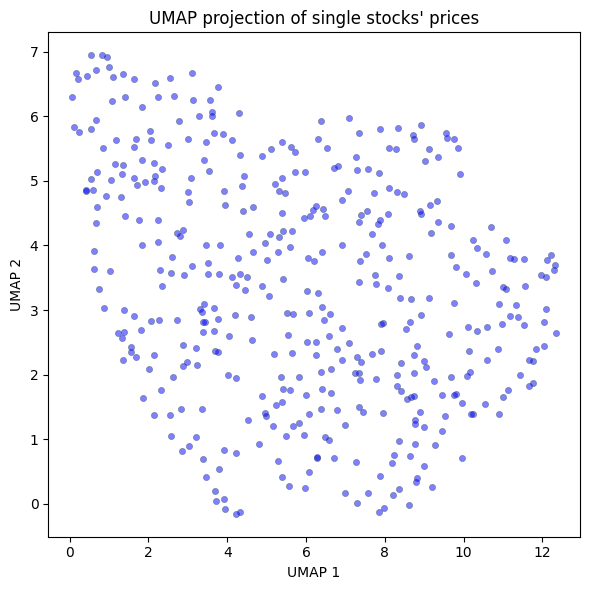

In [27]:
single_stocks = stock_df.query('not is_sector and num_tickers==1 and not is_etf')
single_stocks_prices = prices[single_stocks['name']].T
reducer = umap.UMAP(min_dist=0.5,n_neighbors=15, random_state=42)
reduced_single_stocks = reducer.fit_transform(single_stocks_prices)


plt.figure(figsize=(6, 6))
plt.scatter(
    reduced_single_stocks[:, 0],
    reduced_single_stocks[:, 1],
    c='blue', s=20, edgecolors='darkslategray', linewidth=0.5, alpha=0.5
)
plt.title("UMAP projection of single stocks' prices")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

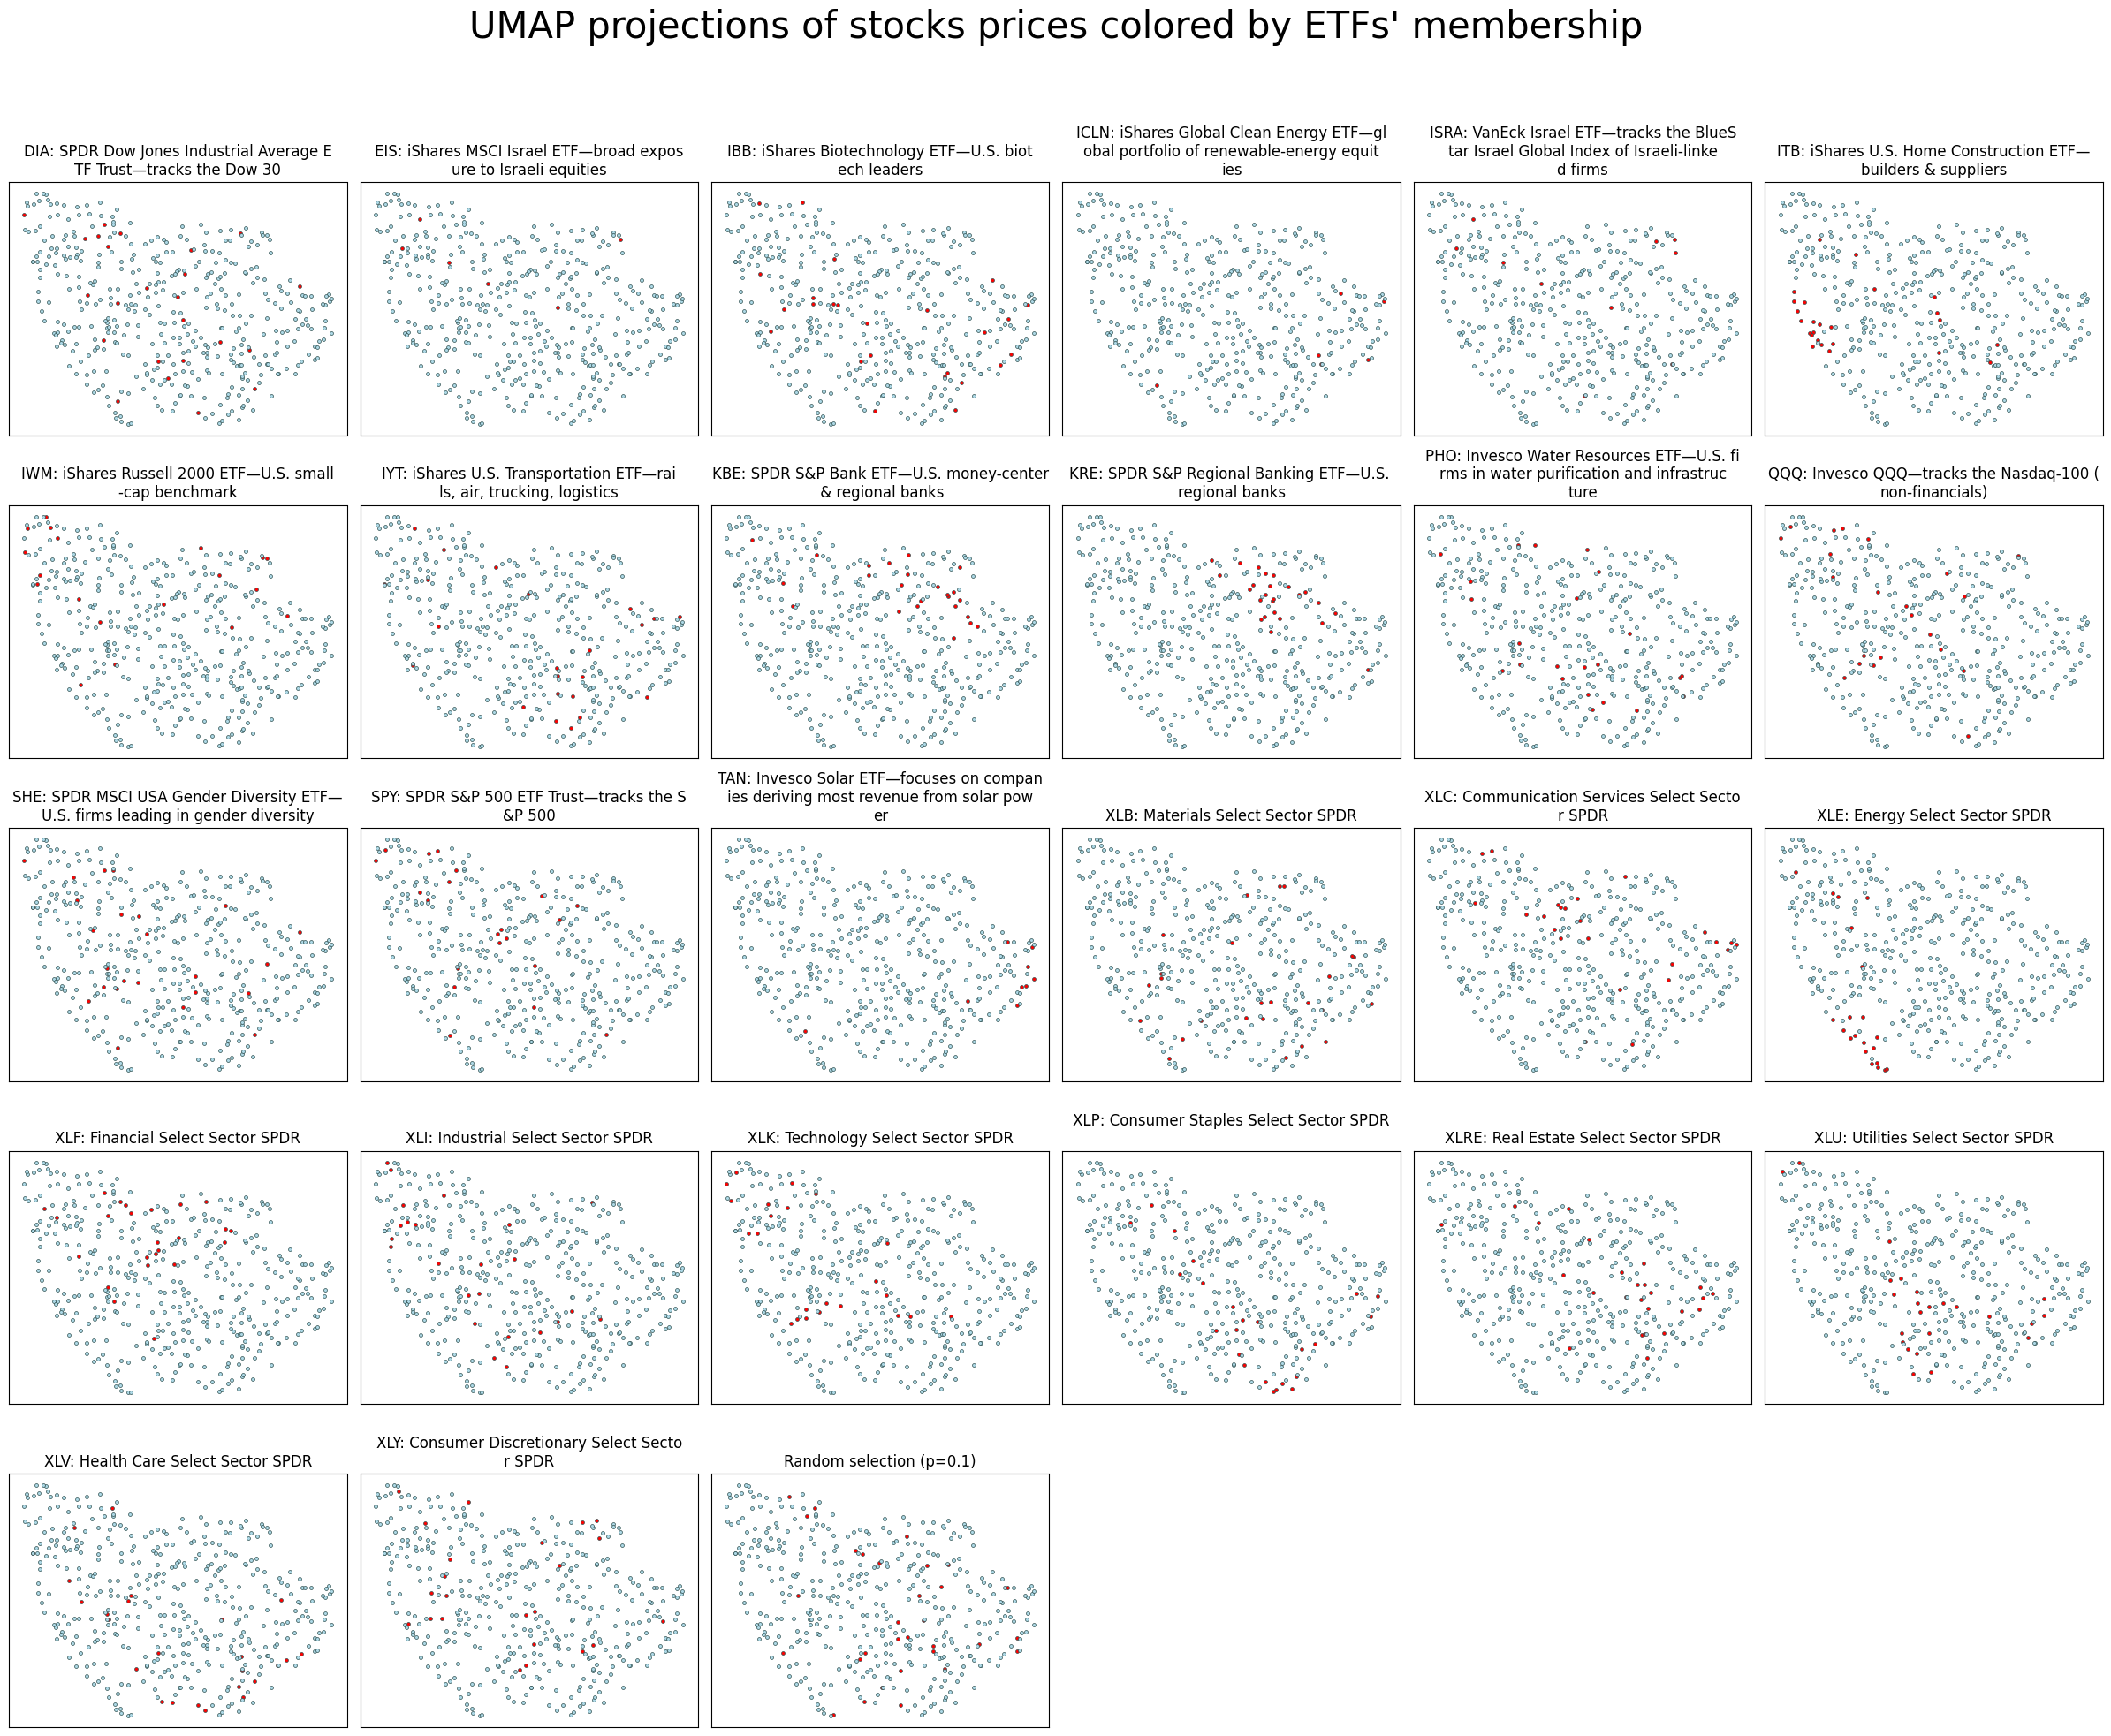

In [28]:
import math
import numpy as np

# include one extra plot for the random reference
n_plots = len(coloring) + 1
cols = int(math.ceil(math.sqrt(n_plots)))
rows = int(math.ceil(n_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

# plot one subplot per ETF
for i, etf_idx in enumerate(coloring.index):
    etf_row = holdings.loc[etf_idx]
    etf_name = f"{etf_row.name}: {etf_row['description']}"
    etf_name = '\n'.join([etf_name[j:j+40] for j in range(0, len(etf_name), 40)])
    if etf_name.endswith('.'):
        etf_name = etf_name[:-1]
    members = set(coloring.iloc[i, 0])
    in_etf = single_stocks['tickers'].apply(lambda x: x[0] in members)

    ax = axes[i]
    ax.scatter(
        reduced_single_stocks[in_etf, 0],
        reduced_single_stocks[in_etf, 1],
        c='red', s=8, edgecolors='darkslategray', linewidth=0.5, label='In'
    )
    ax.scatter(
        reduced_single_stocks[~in_etf, 0],
        reduced_single_stocks[~in_etf, 1],
        c='#ADD8E6', s=8, edgecolors='darkslategray', linewidth=0.5, label='Not in'
    )
    ax.set_title(etf_name)
    ax.set_xticks([])
    ax.set_yticks([])

# plot random selection in the next subplot for reference
ax = axes[len(coloring)]
random_p = 0.1
random_mask = np.random.rand(len(single_stocks)) < random_p
ax.scatter(
    reduced_single_stocks[random_mask, 0],
    reduced_single_stocks[random_mask, 1],
    c='red', s=8, edgecolors='darkslategray', linewidth=0.5, label='In (random)'
)
ax.scatter(
    reduced_single_stocks[~random_mask, 0],
    reduced_single_stocks[~random_mask, 1],
    c='#ADD8E6', s=8, edgecolors='darkslategray', linewidth=0.5, label='Not in (random)'
)
ax.set_title(f'Random selection (p={random_p})')
ax.set_xticks([])
ax.set_yticks([])

# turn off any remaining unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

fig.suptitle(f"{reducer.__class__.__name__.upper()} projections of stocks prices colored by ETFs' membership", fontsize=30)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

/Users/ronraisch/miniforge3/envs/needle/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



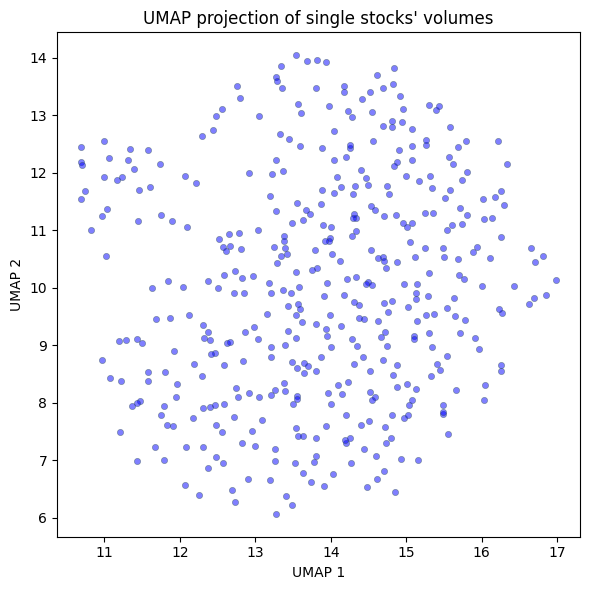

In [29]:
single_stocks = stock_df.query('not is_sector and num_tickers==1 and not is_etf')
single_stocks_volumes = volumes[single_stocks['name']].T
reducer = umap.UMAP(min_dist=0.5,n_neighbors=15, random_state=42)
reduced_single_stocks_volumes = reducer.fit_transform(single_stocks_volumes)


plt.figure(figsize=(6, 6))
plt.scatter(
    reduced_single_stocks_volumes[:, 0],
    reduced_single_stocks_volumes[:, 1],
    c='blue', s=20, edgecolors='darkslategray', linewidth=0.5, alpha=0.5
)
plt.title("UMAP projection of single stocks' volumes")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.tight_layout()
plt.show()

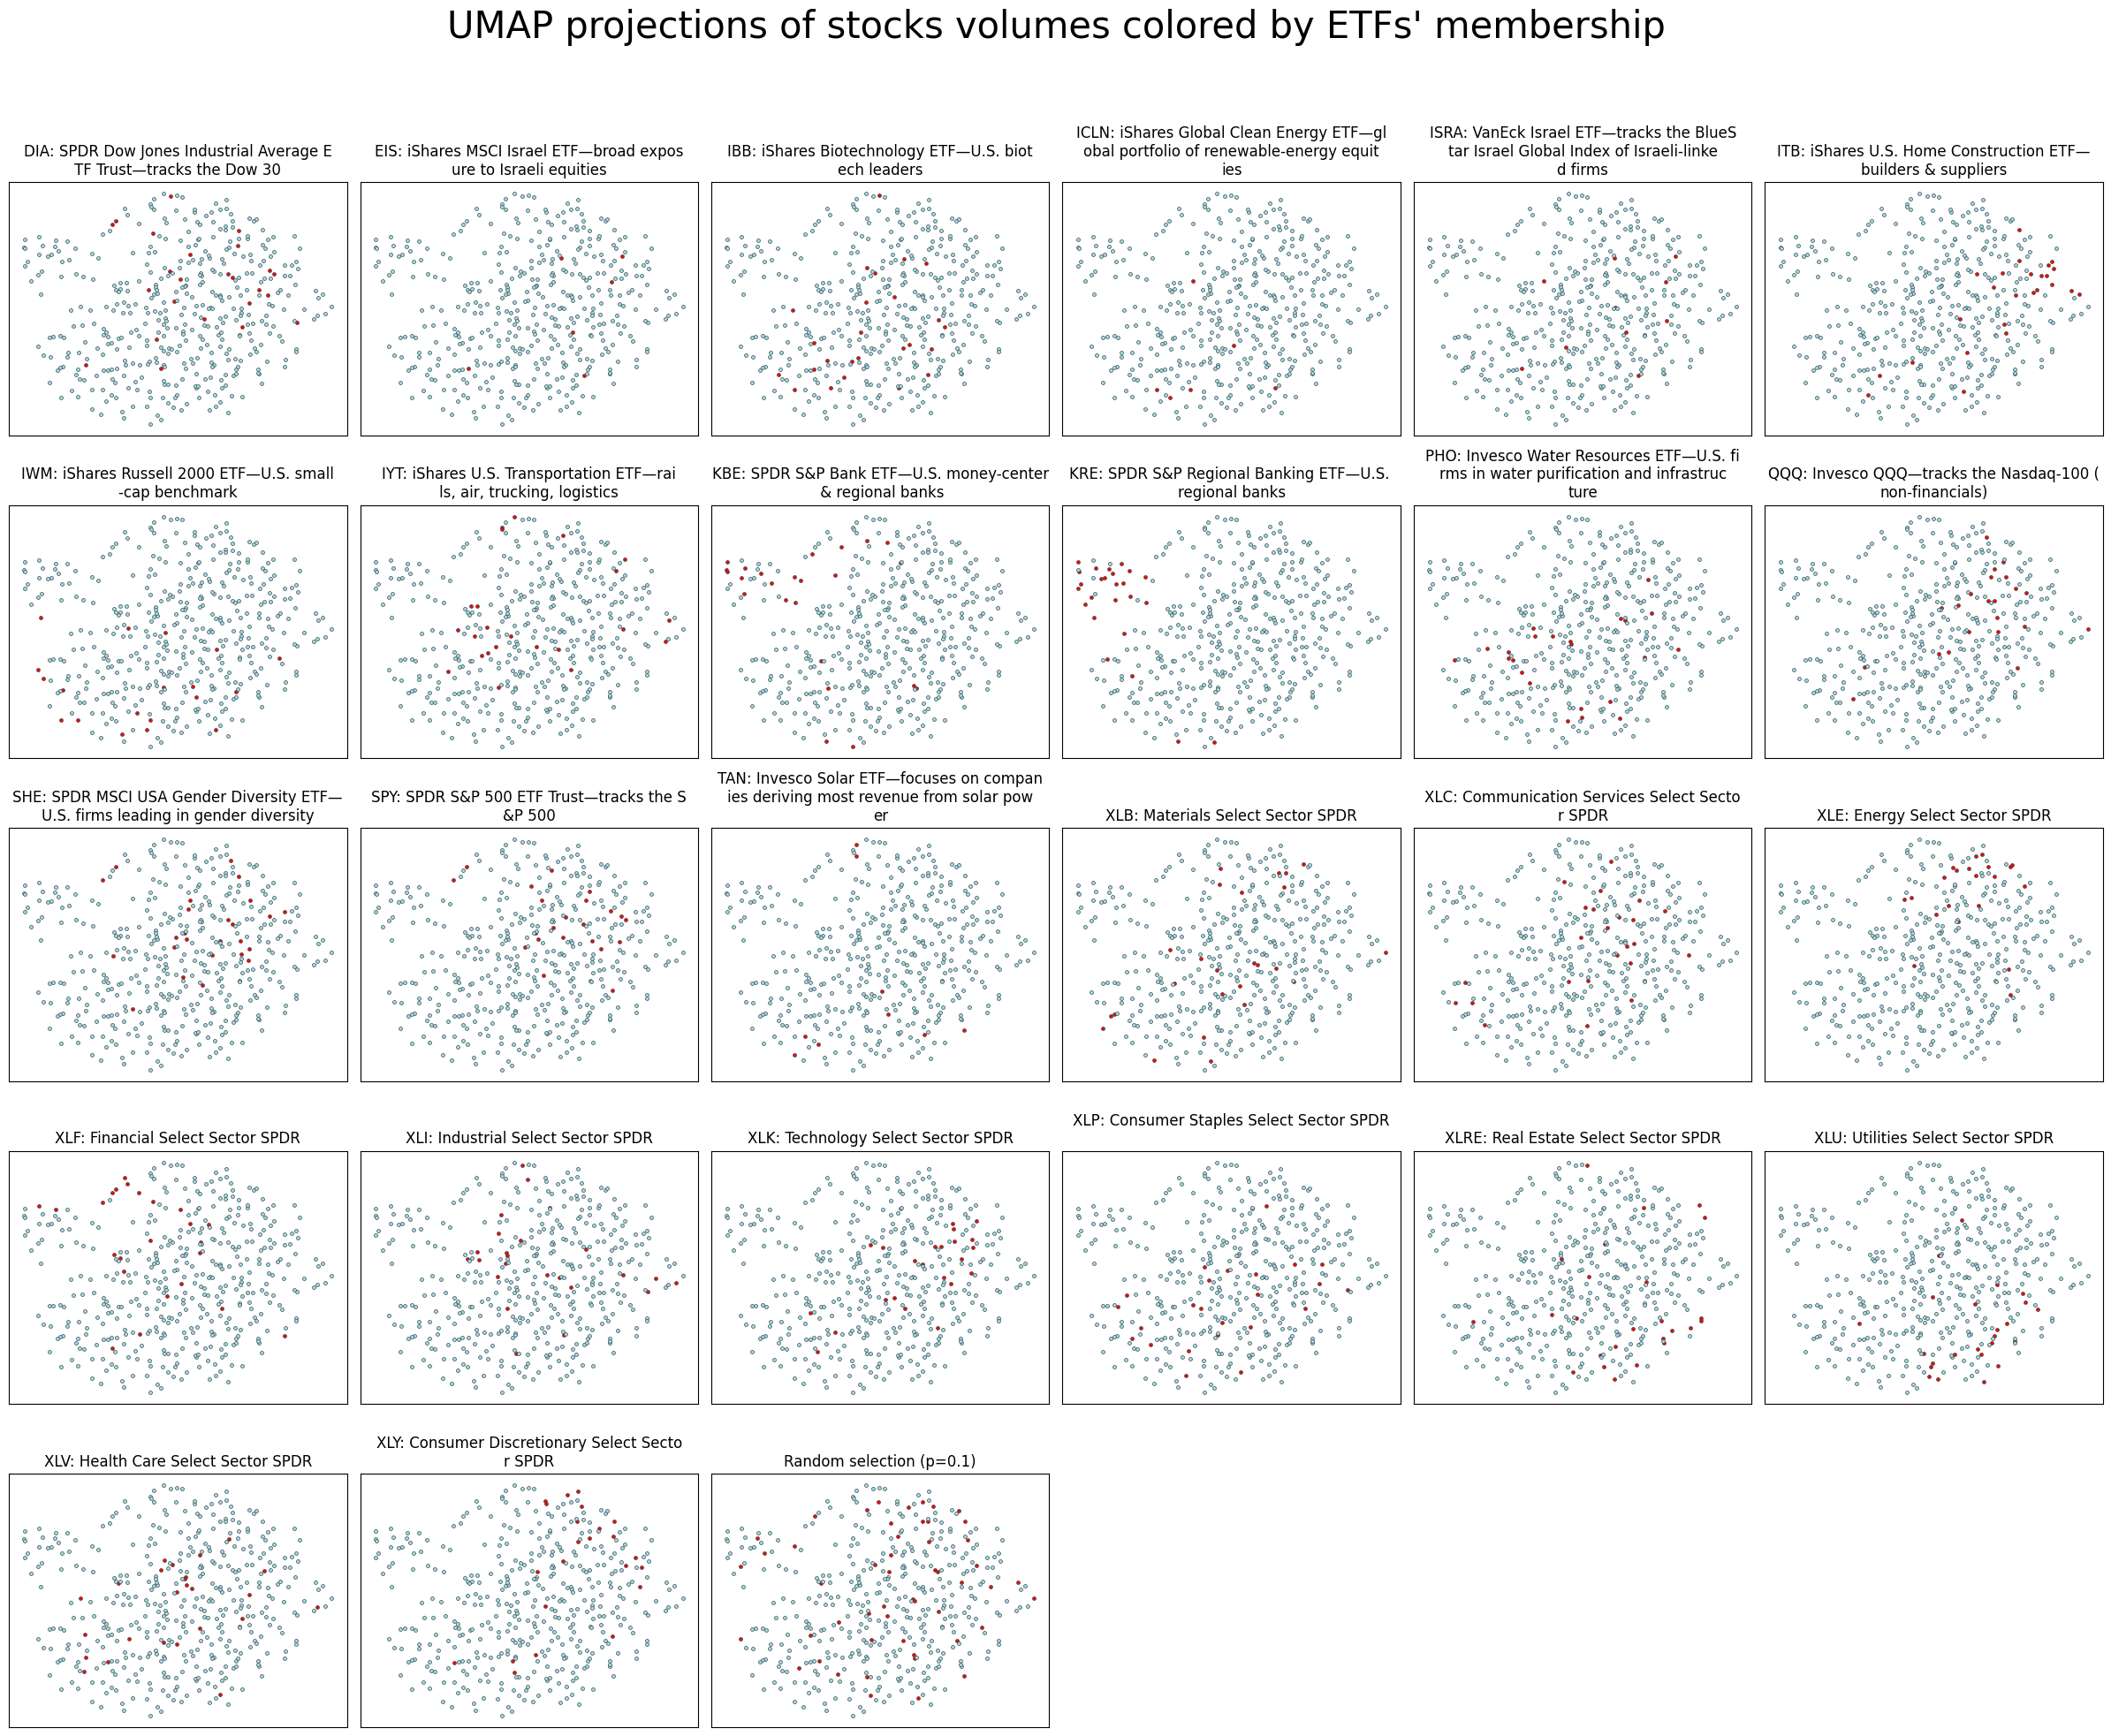

In [30]:
import math
import numpy as np

# include one extra plot for the random reference
n_plots = len(coloring) + 1
cols = int(math.ceil(math.sqrt(n_plots)))
rows = int(math.ceil(n_plots / cols))

fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

# plot one subplot per ETF
for i, etf_idx in enumerate(coloring.index):
    etf_row = holdings.loc[etf_idx]
    etf_name = f"{etf_row.name}: {etf_row['description']}"
    etf_name = '\n'.join([etf_name[j:j+40] for j in range(0, len(etf_name), 40)])
    if etf_name.endswith('.'):
        etf_name = etf_name[:-1]
    members = set(coloring.iloc[i, 0])
    in_etf = single_stocks['tickers'].apply(lambda x: x[0] in members)

    ax = axes[i]
    ax.scatter(
        reduced_single_stocks_volumes[in_etf, 0],
        reduced_single_stocks_volumes[in_etf, 1],
        c='red', s=8, edgecolors='darkslategray', linewidth=0.5, label='In'
    )
    ax.scatter(
        reduced_single_stocks_volumes[~in_etf, 0],
        reduced_single_stocks_volumes[~in_etf, 1],
        c='#ADD8E6', s=8, edgecolors='darkslategray', linewidth=0.5, label='Not in'
    )
    ax.set_title(etf_name)
    ax.set_xticks([])
    ax.set_yticks([])

# plot random selection in the next subplot for reference
ax = axes[len(coloring)]
random_p = 0.1
random_mask = np.random.rand(len(single_stocks)) < random_p
ax.scatter(
    reduced_single_stocks_volumes[random_mask, 0],
    reduced_single_stocks_volumes[random_mask, 1],
    c='red', s=8, edgecolors='darkslategray', linewidth=0.5, label='In (random)'
)
ax.scatter(
    reduced_single_stocks_volumes[~random_mask, 0],
    reduced_single_stocks_volumes[~random_mask, 1],
    c='#ADD8E6', s=8, edgecolors='darkslategray', linewidth=0.5, label='Not in (random)'
)
ax.set_title(f'Random selection (p={random_p})')
ax.set_xticks([])
ax.set_yticks([])

# turn off any remaining unused subplots
for j in range(n_plots, len(axes)):
    axes[j].axis('off')

fig.suptitle(f"{reducer.__class__.__name__.upper()} projections of stocks volumes colored by ETFs' membership", fontsize=30)
fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [64]:
dbscan = DBSCAN(eps=0.52, min_samples=5)
labels = dbscan.fit_predict(reduced_single_stocks)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

-1     14
 0    140
 1    156
 2     84
 3     36
dtype: int64

In [73]:
mask = labels != -1

# use HTML <br> for line break and set the color label to "Cluster"
fig = px.scatter(
    x=reduced_single_stocks[mask, 0],
    y=reduced_single_stocks[mask, 1],
    color=labels[mask].astype(str),
    labels={'color': 'Cluster'},
    hover_name=single_stocks[mask]['name'],
    hover_data={'cluster': labels[mask]},
    title="DBSCAN Clustering of Stock Prices (UMAP Embedding)<br>With outliers removed, four major clusters visible<br>which align well with ETFs and sectors",
    width=600,
    height=600
)
fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey'))
)
fig.update_layout(legend_title_text='Cluster')
fig.show()


In [85]:
dbscan = DBSCAN(eps=0.3, min_samples=5)
labels = dbscan.fit_predict(reduced_single_stocks_volumes)
count = np.unique(labels, return_counts=True)
pd.Series(count[1], index=count[0]).sort_index()

-1     188
 0      14
 1      22
 2      57
 3       8
 4      24
 5       6
 6       7
 7      17
 8       5
 9      21
 10     12
 11      7
 12      5
 13      7
 14      5
 15      8
 16      8
 17      5
 18      4
dtype: int64

In [86]:
mask = labels != -1

# use HTML <br> for line break and set the color label to "Cluster"
fig = px.scatter(
    x=reduced_single_stocks_volumes[mask, 0],
    y=reduced_single_stocks_volumes[mask, 1],
    color=labels[mask].astype(str),
    labels={'color': 'Cluster'},
    hover_name=single_stocks[mask]['name'],
    hover_data={'cluster': labels[mask]},
    title="DBSCAN Clustering (UMAP Embedding) - outliers removed<br>Four major clusters visible which align well with ETFs and sectors",
    width=600,
    height=600
)
fig.update_traces(
    marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey'))
)
fig.update_layout(legend_title_text='Cluster')
fig.show()
